<a href="https://colab.research.google.com/github/yodavo/IAI_vaccines/blob/main/data_wrangling/dataWranglingVAERS(David).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paquetes

In [1]:
# Instalar paquetes no disponibles
!pip install squarify
!pip install fuzzywuzzy
!pip install -U dataprep

# Para importar la data
import os

# Importar para manipulacion de datos
import numpy as np
import pandas as pd
import datetime as dt
from statistics import *

# Importar para Visualizacion 
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import warnings # para evitar warnings
warnings.filterwarnings('ignore')
import textwrap
from textwrap import wrap
import squarify
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Importar Dependencias
%matplotlib inline
%load_ext google.colab.data_table

# Acondicionamiento de Drive y Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Entrando a la carpeta de trabajo
%cd '/content/drive/MyDrive/Colab Notebooks/Diplomado-UTEC/Modulo5/dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Diplomado-UTEC/Modulo5/dataset


# Carga de datos

In [3]:
# Carga de datos

# importar de VAERSData
data = pd.read_csv('2021VAERSData.csv', index_col=0, encoding='latin-1')
print(f'VAERSData\ttiene: {data.shape[0]} observaciones y {data.shape[1]} variables.')

# importar de VAERSVAX
vax = pd.read_csv('2021VAERSVAX.csv', index_col=0, encoding='latin-1')
print(f'VAERSVAX\ttiene: {vax.shape[0]} observaciones y {vax.shape[1]} variables.')

# importar de VAERSSymptoms
symptom = pd.read_csv('2021VAERSSYMPTOMS.csv', index_col=0, encoding='latin-1')
print(f'VAERSSymptoms\ttiene: {symptom.shape[0]} observaciones y {symptom.shape[1]} variables.')

VAERSData	tiene: 428486 observaciones y 34 variables.
VAERSVAX	tiene: 445358 observaciones y 7 variables.
VAERSSymptoms	tiene: 575022 observaciones y 10 variables.


# Preparacion de datos de vacunas (**VAERSVAX**)

Se utilizo informacion de VAX_MANU y VAX_TYPE para hacer el filtro de:

1.**VAX_MANU** -- Para eliminar 'UNKNOWN MANUFACTURER'
2.**VAX_TYPE** -- Para filtrar vacunas de COVID19

**Una vez usadas se eliminaron las siguientes variables:**
1. **VAX_NAME** (por tener la misma informaciond de VAX_MANU)
2.**VAX_TYPE** (por que despues del filtrado no aporta mas informacion)

In [4]:
# TRATANDO VAX
# eliminamos frabricante desconocido y seleccionamos solamente los datos de covid19
vac = vax.loc[(vax['VAX_MANU'] != 'UNKNOWN MANUFACTURER') & (vax['VAX_TYPE'] == 'COVID19')] 
print(vac.shape)

(437645, 7)


In [5]:
# eliminamos repetidos y variables de filtrado
vacuna = vac.loc[vac.index.drop_duplicates(keep=False)]
vacuna.drop(columns = ['VAX_NAME', 'VAX_TYPE'], inplace = True)
print(vacuna.shape) # no duplicados, lista para ser combinada

(409006, 5)


In [6]:
# separando el dataset de vacunas de covid19
print(f"Tamaño dataset original: {vax.shape[0]} observaciones y {vax.shape[1]} variables")
print(f"Tamaño dataset COVID19: {vacuna.shape[0]} observaciones y {vacuna.shape[1]} variables")

Tamaño dataset original: 445358 observaciones y 7 variables
Tamaño dataset COVID19: 409006 observaciones y 5 variables


# Merge de datasets **VAERVAX** (vacuna) y **VAERSData** (data), basada en 'vacuna' - variable global : **dataset_covid**

Lamentablemente, el dataset sympthoms esta contaminado con informacion de laboratorio, medicamenttos y otros. Por lo que no fue tomada en cuenta para el analisis.

In [7]:
dataset_covid = pd.merge(vacuna, data, on='VAERS_ID')
print(f'El dataset de VAERS para vacunas covid tiene: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables')

El dataset de VAERS para vacunas covid tiene: 409006 observaciones y 39 variables


# **Variables que no aportan informacion para este estudio**

1. **RPT_DATE** -- Fecha de llenado del reporte, no es necesaria para este estudio (preferimos la fecha de carga del reporte).
2. **SPLTTYPE** -- Numero de proyecto de fabricante, no es necesaria para este estudio.
3. **TODAYS_DATE** -- Fecha de subida a la base de datos, no es indispensable.


In [8]:
## Variables no necesarias
rejected_col = ['RPT_DATE', 'SPLTTYPE', 'TODAYS_DATE']
print(f"Antes: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")
dataset_covid.drop(rejected_col, axis=1, inplace=True)
print(f"Despues: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")

Antes: 409006 observaciones y 39 variables
Despues: 409006 observaciones y 36 variables


# **Variables que necesitan observación por el metodo de coleccion de datos**

1. **FORM_VERS ** -- En la colecta de los datos, tenemos dos factores importantes, primero la naturaleza del formulario que se utilizo para **(FORM_VERS)** teniendo dos formularios:

  - Form1 - Impreso (289 observaciones)
  - Form2 - Online (408717 observaciones)

  Como observamos la version impresa tiene una cantidad no significativa en comparacion de los otros datos. **Lo que nos permite eliminarla.**

  **En consecuencia de la eliminacion de los formularios 1,** existen otras variables tomadas juntamente con este formato, que se analiza a continuación:
  2. **V_FUNDBY** -- Tipos de financiamiento usado para la vacunación. **Se elimino por poseer data insuficiente.**

  3. **VAX_DOSE_SERIES** -- Numero de dosis administradas. Esta variable no es confiable debido a su *descontinuacion* en el formulario. A pesar de eso se relizo una limpieza a traves de la eliminacion de observaciones (fila entera) donde se observo mas de 3 dosis de vacunas. Importante saber que en estos casos excedentes, se observaron: 
    - MODERNA (644 obs excedentes de 3 dosis)
    - PFIZER-BIONTECH (585 obs excedentes de 3 dosis)
    - JANSSEN (85 obs excedentes de 3 dosis)
  
    **Reportando 11 fallecidos (por Moderna y Pfizer) y 17 hospitalizados por todas las vacunas (para mas detalle ver el codigo abajo).** Una vez usado para el filtro, se conservo la variables para separar por grupos de dosis de vacunas (para evaluar)

  4. **HISTORY** -- Condiciones cronicas y enfermedades duraderas reportadas. Al momento de analizar la informacion se vio una cantidad de datos considerable por lo que se dio incio con la creacion de una lista de palabras a ignorar (**'palabras_erroneas', importante por que usara para todo el dataset**, ya que será actualizado en cada variable que reciba variables textuales) y **se observó que la variable tenian un valor significativo en el dataset, por lo que no fue eliminada y sera procesada por NPL mas adelante.**
  5.**ER_VISIT** -- Visita a sala de emergencia o doctor. Debido a que tiene similitud con otras variables sera procesada mas adelante.





In [9]:
# Filtrando FORM_VERS para quedarnos solo con formularios 2
dataset_covid = dataset_covid.loc[dataset_covid.FORM_VERS == 2]
# Eliminando la variable FORM_VERS ya que no sera necesaria para mas adelante
dataset_covid.drop(columns= 'FORM_VERS', inplace=True)

In [10]:
# Eliminando la variable V_FUNDBY por ser desestimada por pocos datos sginificativos
dataset_covid.drop(columns= 'V_FUNDBY', inplace=True)

In [11]:
# Analisis de VAX_DOSE_SERIES
dataset_covid['VAX_DOSE_SERIES'] = dataset_covid['VAX_DOSE_SERIES'].str.lower().replace('unk', np.nan) # reemplazando valores desconocidos (UNK)

# revision de dosis exageradas (ESTA SECCION ES SOLO PARA REPORTE, LOS DATOS SE ELIMINARON DE LA BASE DE DATOS)
outliers_dosis = dataset_covid.loc[dataset_covid['VAX_DOSE_SERIES'].isin(['4', '5', '6', '7+'])]
print(f'Valores fuera de los rangos de estudio: \n')
print(outliers_dosis.VAX_MANU.value_counts())
print(f'\nValores de fallecidos: \n')
print(outliers_dosis.groupby(['VAX_MANU', 'DIED']).size())
print(f'\nValores de hospitalizados: \n')
print(outliers_dosis.groupby(['VAX_MANU', 'HOSPITAL']).size())

# eiminar valores de dosis excedentes
print(f"\n\nAntes: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")
dataset_covid = dataset_covid[~dataset_covid['VAX_DOSE_SERIES'].isin(['4', '5', '6', '7+'])]
print(f"Despues: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")

Valores fuera de los rangos de estudio: 

MODERNA            278
PFIZER\BIONTECH    110
JANSSEN             61
Name: VAX_MANU, dtype: int64

Valores de fallecidos: 

VAX_MANU         DIED
MODERNA          Y       9
PFIZER\BIONTECH  Y       2
dtype: int64

Valores de hospitalizados: 

VAX_MANU         HOSPITAL
JANSSEN          Y            2
MODERNA          Y           11
PFIZER\BIONTECH  Y            4
dtype: int64


Antes: 408717 observaciones y 34 variables
Despues: 408268 observaciones y 34 variables


In [12]:
# Creacion de las lista de palabras_erroneas (palabras a ignorar)
palabras_errones = ['none', 'no', 'comments: unknown', 'unknown',
                    'comments: list of non-encoded patient relevant history: patient other relevant history 1: none',
                    'medical history/concurrent conditions: no adverse event (no reported medical history)', 
                    'none reported', 'medical history/concurrent conditions: no adverse event (no medical history reported)',
                    'medical history/concurrent conditions: no adverse event (no reported medical history.)',
                    'none known', 'na', 'medical history/concurrent conditions: no adverse event (no medical history reported.)',
                    'none listed', 'unk', 'comments: the patient had no known allergies.', 'no.', 
                    '0', 'non', 'yes', 'none noted', 'none stated', 'no known', 'comments: list of non-encoded patient relevant history: patient other relevant history 1: no',
                    'nothing', 'comments: no medical history was provided by the reporter.',
                    'comments: list of non-encoded patient relevant history: patient other relevant history 1: no',
                    'comments: the patient had no known drug allergies.', 'nothing'
]

# Se analizara HISTORY mas adelante cuando se utilice NPL

# **Filtrado de Variables.**

In [15]:
############################# BACKUP ######################################
#backupMayor = dataset_covid.copy()

In [91]:
# recover
dataset_covid = backupMayor.copy()

##**1.RECVDATE**

Fecha de ingreso de reporte. Sin cambio

In [92]:
# Procesamiento de RECVDATE, formato de fecha
dataset_covid['RECVDATE'] =  dataset_covid['RECVDATE'].apply(pd.to_datetime, format='%m/%d/%Y') # no contiene ningun valor vacio

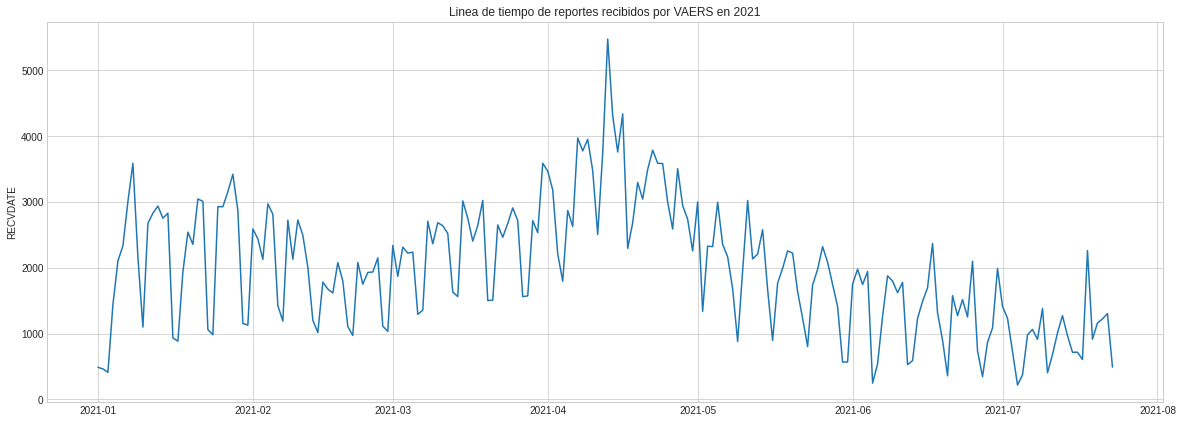

In [93]:
# variable para plotear
recvdate = dataset_covid['RECVDATE'].value_counts()

# grafico de fecha de ingreso de reportes
plt.figure(figsize=(20,7))
sns.lineplot(data = recvdate)
plt.title('Linea de tiempo de reportes recibidos por VAERS en 2021')
plt.show()


## **2. STATE**

Se conservaron solo estados de USA, los territorios y nan fueron cambiados por **NSP**

In [94]:
# Lista  de estados de los Estados Unidos de America
usa_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [95]:
# Obteniendo datos erroneos para correcion
dataset_covid['STATE'] = dataset_covid['STATE'].str.upper() # volver tod el codigo a mayusculas
dataset_covid['STATE'] = dataset_covid['STATE'].str.strip() # quitar espacios en blanco
erroneo = dataset_covid['STATE'].value_counts().index.tolist() # seleccionar valores para comparar con los estados
cambio = list(set(erroneo) - set(usa_states)) # para comprobar la differencia
for i in cambio:
  print(i, dataset_covid.loc[dataset_covid['STATE'] == i].shape)

XB (3, 34)
VI (32, 34)
XL (1, 34)
AS (33, 34)
XV (2, 34)
FM (3, 34)
MP (13, 34)
MH (7, 34)
GU (58, 34)
PR (1495, 34)
QM (1, 34)


In [96]:
#reemplazo de valores y valores nan
dataset_covid['STATE'] = dataset_covid['STATE'].replace(cambio, np.nan) # reemplazando los valores de territorios
dataset_covid['STATE'] = dataset_covid['STATE'].fillna('NSP') # definiendo no especifica

## **3. AGE_YRS, CAGE_YR, CAGE_MO**

Se combino CAGE_YR y CAGE_MO para rescatar la edad si no fue brindada en AGE_YRS.
Se convitieron las edades en numeros integrales y todo se establecio en la variable AGE_YRS

In [97]:
# Analisis por datos vacios
print(dataset_covid.AGE_YRS.isnull().sum(), dataset_covid.AGE_YRS.dtype)
print(dataset_covid.CAGE_YR.isnull().sum(), dataset_covid.CAGE_YR.dtype)
print(dataset_covid.CAGE_MO.isnull().sum(), dataset_covid.CAGE_MO.dtype)

27890 float64
61722 float64
407494 float64


In [98]:
# revisamos cuantos datos podemos recuperar las edades
print('Se puede recuperar: ', dataset_covid.loc[~dataset_covid['CAGE_YR'].isnull()].AGE_YRS.isnull().sum(), 'edades no anotadas')

Se puede recuperar:  1466 edades no anotadas


In [99]:
#Preparamos la nueva columna
dataset_covid.AGE_YRS = dataset_covid.AGE_YRS.fillna(0).astype('int')
dataset_covid.CAGE_YR = dataset_covid.CAGE_YR.fillna(0).astype('int') # cambiamos tipo para concatenar
dataset_covid.CAGE_MO = dataset_covid.CAGE_MO.fillna(0).astype('int') # cambiamos tipo para concatenar

In [100]:
# creamos una nueva columna
dataset_covid['EDADexp'] = dataset_covid.CAGE_YR.astype(str) + '.' + dataset_covid.CAGE_MO.astype(str)
dataset_covid['EDADexp'] = dataset_covid['EDADexp'].astype(float).round()
dataset_covid['EDADexp'] = dataset_covid['EDADexp'].astype(int)

In [101]:
# Recuperando valores en AGE_YRS
print('Antes de recuperar las edades de CAGE se tenian:\t', dataset_covid.loc[dataset_covid['AGE_YRS'] != 0].shape[0], 'observaciones')
dataset_covid['AGE_YRS'] = np.where(dataset_covid['AGE_YRS'] == 0, dataset_covid['EDADexp'], dataset_covid['AGE_YRS'])
print('Despues de recuperar las edades de CAGE se tienen:\t', dataset_covid.loc[dataset_covid['AGE_YRS'] != 0].shape[0], 'observaciones')

Antes de recuperar las edades de CAGE se tenian:	 380318 observaciones
Despues de recuperar las edades de CAGE se tienen:	 381623 observaciones


In [102]:
# Eliminamos las columnas que no nos brindan mas datos utiles
remove = ['EDADexp', 'CAGE_YR', 'CAGE_MO']
dataset_covid.drop(columns=remove, inplace=True)

## **4. SEX**

Se eliminaron los record con sexo desconocido (U)

In [103]:
print(f'Antes de eliminar los sexos desconocidos se tenian {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables')
# Eliminamos valores U, no aportan nada al estudio
dataset_covid = dataset_covid.loc[dataset_covid['SEX'] != 'U']
print(f'Despues de eliminar los sexos desconocidos se tenian {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables')
print(dataset_covid.SEX.value_counts())

Antes de eliminar los sexos desconocidos se tenian 408268 observaciones y 32 variables
Despues de eliminar los sexos desconocidos se tenian 398229 observaciones y 32 variables
F    285023
M    113206
Name: SEX, dtype: int64


## **5. DIED, DATE_DIED**

Se conservo, se confirmo la muerte y luego se mejoro los errores en la fecha.

In [104]:
# Analisis por datos vacios
print(dataset_covid.DIED.notnull().sum(), dataset_covid.DIED.dtype)
print(dataset_covid.DATEDIED.notnull().sum(), dataset_covid.DATEDIED.dtype)

4850 object
4489 object


In [105]:
# Preparando DIED, solo se imputo los valores vacios por N
dataset_covid.DIED = dataset_covid.DIED.fillna('N').astype('str')

In [106]:
# Preparando los datos de DATEDIED
new = dataset_covid["DATEDIED"].str.split("/", n = 2, expand = True)
dataset_covid['mes']= new[0]
dataset_covid['dia']= new[1]
dataset_covid['anio']= new[2]

# lista para uso con fechas
new = ['mes','dia','anio']

#revision de todo
# for i in new:
#   display(dataset_covid[i].value_counts().sort_index())

# El problema detectado fue el año
display(dataset_covid['anio'].value_counts().sort_index())

2001       1
2010       1
2014       1
2020      31
2021    4455
Name: anio, dtype: int64

In [107]:
# revisando valores atipicos
dataset_covid.loc[dataset_covid['anio'].isin(['2001','2010','2014'])]

,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,RECVDATE,STATE,AGE_YRS,SEX,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,mes,dia,anio
VAERS_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
930912,PFIZER\BIONTECH,NaN,NaN,UN,UN,2021-01-09,NY,73,M,Diarrhea followed by death 24 hrs after vaccin...,Y,01/08/2001,NaN,NaN,NaN,NaN,NaN,NaN,N,01/07/2021,01/08/2021,1.0,NaN,UNK,None,None,None,NaN,NaN,NaN,NaN,None,01,08,2001
1050128,PFIZER\BIONTECH,EM9810,NaN,IM,LA,2021-02-23,WV,70,M,"02/07/21 through 2/13/21 slightly fatiqued, to...",Y,02/14/2014,NaN,NaN,NaN,NaN,NaN,NaN,N,02/06/2021,02/07/2021,1.0,NaN,PUB,"Eliquis 5MG, Carvedilol 6.25MG, Ramipril 2.5 M...",none,1.COPD started in 2008 from a Neurosurgery and...,NaN,NaN,NaN,Y,Penicillin,02,14,2014
1133747,MODERNA,030M20A,NaN,IM,LA,2021-03-25,NSP,97,M,died on hospice Narrative: Patient died on ho...,Y,03/14/2010,NaN,NaN,NaN,NaN,Y,NaN,N,NaN,03/14/2021,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,Y,Y,NaN,03,14,2010


 Revision, se reemplaza los años por revision individual de la siguiente manera

 - 2001 -> 2021
 - 2021 -> 2021
 - 2014 -> 2021

In [108]:
# Reemplazando valores
dataset_covid['anio'].replace({'2001': '2021', 
                               '2010': '2021',
                               '2014': '2021'}, inplace=True)

# funcion para reemplazar tiempo
dataset_covid.DATEDIED = dataset_covid['anio'] + '-' + dataset_covid['mes'] + '-' + dataset_covid['dia']

# eliminando columnas temporales
dataset_covid.drop(columns=new, inplace=True)

# transformando a fecha
dataset_covid['DATEDIED'] =  pd.to_datetime(dataset_covid['DATEDIED'], format='%Y-%m-%d')

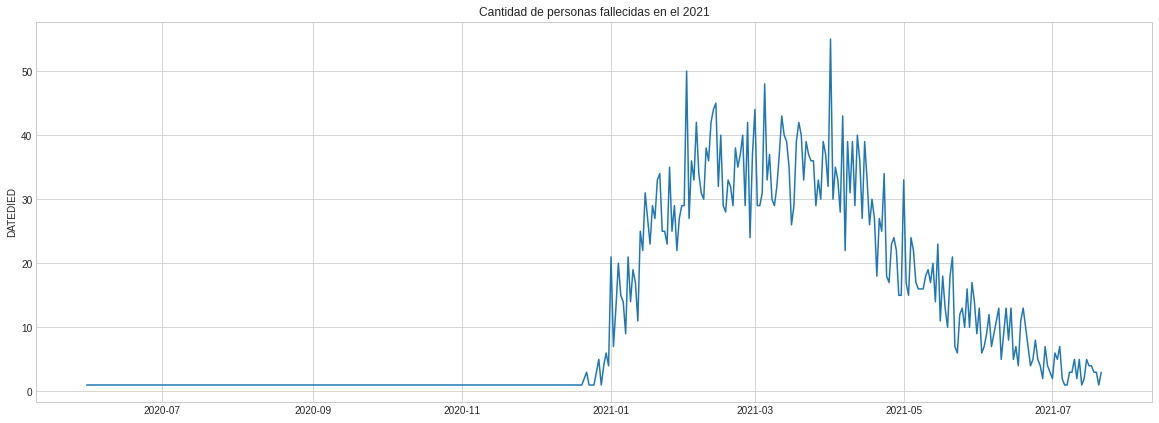

In [109]:
# grafico por fechas y de personas fallecidas
plt.figure(figsize=(20,7))
sns.lineplot(data = dataset_covid['DATEDIED'].value_counts())
plt.title('Cantidad de personas fallecidas en el 2021')
plt.show()

## **6.ER_VISIT, ER_ED_VISIT, OFC_VISIT**

En el caso de las dos primeras tienen la mismas info pero estan colectadas en diferentes formulario.

En el caso de la tercera contiene informacion explicita en ER_VISIT por lo que se todas estas variables se combinaron en ER_ED_VISIT.


Se transformo Y en 1 y nan n 0

In [110]:
print(f'Valores vacios en ER_ED_VISIT:\t{dataset_covid.ER_ED_VISIT.isnull().sum()}')
print(f'Valores vacios en ER_VISIT:\t{dataset_covid.ER_VISIT.isnull().sum()}')
print(f'Valores vacios en OFC_VISIT:\t{dataset_covid.OFC_VISIT.isnull().sum()}')

Valores vacios en ER_ED_VISIT:	344579
Valores vacios en ER_VISIT:	398229
Valores vacios en OFC_VISIT:	319279


In [111]:
# preparando las columnas para ser combinadas (imputando por binario)
dataset_covid.ER_VISIT.fillna(0, inplace=True)
dataset_covid.ER_ED_VISIT.fillna(0, inplace=True)
dataset_covid.OFC_VISIT.fillna(0, inplace=True)

In [112]:
# preparando formato de columnas
er_ed = dataset_covid['ER_ED_VISIT'].astype(str)
er_vi = dataset_covid['ER_VISIT'].astype(str)
of_vi = dataset_covid['OFC_VISIT'].astype(str)

# combinando las columnas en una sola variable (ER_ED_VISIT)
dataset_covid.ER_ED_VISIT = er_ed + er_vi + of_vi

# revisando valores
dataset_covid.ER_ED_VISIT.value_counts()

000    281957
00Y     62622
Y00     37322
Y0Y     16328
Name: ER_ED_VISIT, dtype: int64

In [113]:
# reemplazando valores
dataset_covid['ER_ED_VISIT'].replace({'000': 0, 
                               'Y00': 1,
                               'Y0Y': 1,
                               '00Y': 1}, inplace=True)

# revisando valores
dataset_covid.ER_ED_VISIT.value_counts()

0    281957
1    116272
Name: ER_ED_VISIT, dtype: int64

In [114]:
print(f'Antes del filtrado teniamos {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables.')
# Eliminamos variables que ya no son utiles ('ER_VISIT', 'OFC_VISIT')
dataset_covid.drop(columns=['ER_VISIT', 'OFC_VISIT'], inplace=True)
print(f'Despues del filtrado teniamos {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables.')

Antes del filtrado teniamos 398229 observaciones y 32 variables.
Despues del filtrado teniamos 398229 observaciones y 30 variables.


## **7.HOSPITAL, HOSPDAYS**

Se imputo con 0 los valores valores faltante y se cambio Y por 1 en hospitalizados.

Los dias de hospitalizacin llegan hasta 120 dias.

In [115]:
# imputamos valores en dias con 0 y volvemos binario en hospitalizacion
dataset_covid.HOSPITAL.fillna(0, inplace=True) # imputando nan por 0 en hospitalizados
dataset_covid.HOSPDAYS.fillna(0, inplace=True) # imputando nan por 0 en dias hospitalizados
dataset_covid.HOSPITAL.replace('Y',1, inplace=True) # cambiamos y por 1 en hospitalizados

# coercionamos los valores a int
dataset_covid.HOSPITAL = dataset_covid.HOSPITAL.astype(int)
dataset_covid.HOSPDAYS = dataset_covid.HOSPDAYS.astype(int)

In [116]:
# revisando valores
A = (dataset_covid.HOSPDAYS != 0) & (dataset_covid.HOSPITAL != 0)
B = (dataset_covid.HOSPDAYS == 0) & (dataset_covid.HOSPITAL != 0)
C = (dataset_covid.HOSPDAYS != 0) & (dataset_covid.HOSPITAL == 0)

# comprobando que los valores sean iguales!
print('Datos de pacientes hospitalizados (Y)\t:', (dataset_covid.HOSPITAL != 0).sum())
print('Al menos 1 dia de hospitalizacion\t:', (dataset_covid.HOSPDAYS != 0).sum())
print(f'Pacientes con datos dias de hospitalizacion y con record de hospitalizado (Y) : {dataset_covid.loc[A].shape[0]}')
print(f'Pacientes sin datos dias de hospitalizacion y con record de hospitalizado (Y) : {dataset_covid.loc[B].shape[0]}')
print(f'Pacientes con datos dias de hospitalizacion y sin record de hospitalizado (Y) : {dataset_covid.loc[C].shape[0]}')

Datos de pacientes hospitalizados (Y)	: 22362
Al menos 1 dia de hospitalizacion	: 15900
Pacientes con datos dias de hospitalizacion y con record de hospitalizado (Y) : 15900
Pacientes sin datos dias de hospitalizacion y con record de hospitalizado (Y) : 6462
Pacientes con datos dias de hospitalizacion y sin record de hospitalizado (Y) : 0


Se pueden mejorar los datos en base al siguiente enunciado.

> Todo paciente hospitalizados (Y) deben tener al menos 1 dia de hospitalizacion.

In [117]:
# cambio usando condicional (B) previamente usada
dataset_covid['HOSPDAYS'] = np.where(B, 1, dataset_covid['HOSPDAYS'])

In [118]:
# revisando valores
A = (dataset_covid.HOSPDAYS != 0) & (dataset_covid.HOSPITAL != 0)
B = (dataset_covid.HOSPDAYS == 0) & (dataset_covid.HOSPITAL != 0)
C = (dataset_covid.HOSPDAYS != 0) & (dataset_covid.HOSPITAL == 0)

# comprobando nuevamente
print(f'Pacientes con datos dias de hospitalizacion y con record de hospitalizado (Y) : {dataset_covid.loc[A].shape[0]}')
print(f'Pacientes sin datos dias de hospitalizacion y con record de hospitalizado (Y) : {dataset_covid.loc[B].shape[0]}')

Pacientes con datos dias de hospitalizacion y con record de hospitalizado (Y) : 22362
Pacientes sin datos dias de hospitalizacion y con record de hospitalizado (Y) : 0


In [119]:
# revisando valores excedentes en HOSPDAYS
dataset_covid.HOSPDAYS = np.where(dataset_covid.HOSPDAYS > 120, 0, dataset_covid.HOSPDAYS) # para eliminar valores 999 999 99999
dataset_covid.HOSPDAYS.value_counts().sort_index()

0      375869
1        9382
2        3488
3        2737
4        1770
        ...  
95          1
97          1
104         1
117         1
120         2
Name: HOSPDAYS, Length: 76, dtype: int64

## **8. L_THREAT**

Cambio de Y por 1 y nan por 0

In [121]:
# cambiando por valores binarios
dataset_covid.L_THREAT.fillna('0', inplace=True) # rellenando nan con 0
dataset_covid.L_THREAT.replace('Y', 1, inplace=True)
dataset_covid.L_THREAT = dataset_covid.L_THREAT.astype(int) # voviendolo int
dataset_covid.L_THREAT.value_counts()

0    391767
1      6462
Name: L_THREAT, dtype: int64

# **9. DISABLE**

Cambio de Y por 1 y nan po 0

In [123]:
# cambiando por valores binarios
dataset_covid.DISABLE.fillna('0', inplace=True) # rellenando nan con 0
dataset_covid.DISABLE.replace('Y', 1, inplace=True)
dataset_covid.DISABLE = dataset_covid.DISABLE.astype(int) # voviendolo int
dataset_covid.DISABLE.value_counts()

0    392691
1      5538
Name: DISABLE, dtype: int64

# **10. BIRTH_DEFECT, X_STAY**

Ambas no representa un valor significante (solo 199 pacientes en BIRTH DEFECT y 235 en X_STAY), ademas no especifica el defecto de nacimiento por lo que no es indispensable para este estudio, ni la cantidad de dias de hospitalizacion excedente.

**Ambas fueron eliminadas.**

In [133]:
print(f'Antes del filtro se tenian: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables.')
dataset_covid.drop(columns=['BIRTH_DEFECT','X_STAY'], inplace=True)
print(f'Despues del filtro se tenian: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables.')

Antes del filtro se tenian: 398229 observaciones y 30 variables.
Despues del filtro se tenian: 398229 observaciones y 28 variables.


# **11.RECOVD**

Se imputaron con valores U (desconocidos) de periodos de recuperacion de los pacientes. Necesita mas evaluacion.

In [142]:
print(f'Antes de imputar:\n{dataset_covid.RECOVD.value_counts()}\n')
# imputanod valores
dataset_covid.RECOVD.fillna('U', inplace=True)
print(f'Despues de imputar:\n{dataset_covid.RECOVD.value_counts()}\n')

Antes de imputar:
N    147669
Y    144558
U     67393
Name: RECOVD, dtype: int64

Despues de imputar:
N    147669
Y    144558
U    106002
Name: RECOVD, dtype: int64



# **12. VAX_DATE, VAX_ONSET**
Multiples errores, corregidos y mapeado desde la informacion de fecha de reporte del formulario. 

In [399]:
# Preparando los datos de VAX_DATE
new_vax = dataset_covid["VAX_DATE"].str.split("/", n = 2, expand = True)
dataset_covid['mes_vax']= new_vax[0]
dataset_covid['dia_vax']= new_vax[1]
dataset_covid['anio_vax']= new_vax[2]

# lista para uso con fechas
new_vax = ['mes_vax','dia_vax','anio_vax']

# revision de todo
# for i in new_vax:
#  display(dataset_covid[i].value_counts().sort_index())

In [400]:
# Preparando los datos de ONSET_DATE
new_ons = dataset_covid["ONSET_DATE"].str.split("/", n = 2, expand = True)
dataset_covid['mes_ons']= new_ons[0]
dataset_covid['dia_ons']= new_ons[1]
dataset_covid['anio_ons']= new_ons[2]

# lista para uso con fechas
new_ons = ['mes_ons','dia_ons','anio_ons']

# revision de todo
# for i in new_ons:
#  display(dataset_covid[i].value_counts().sort_index())

> El problema detectado fueron los **años**, y se hara un filtro para revisar si esta informacion es recuperable

In [401]:
# creamos una lista de revision
revisar1 = dataset_covid['anio_vax'].dropna().astype(float).astype(int)
revisar1 = list(set([str(x) for x in revisar1 if x < 2020]))
#revisar1 # lista de años errados en vax

revisar2 = dataset_covid['anio_ons'].dropna().astype(float).astype(int)
revisar2 = list(set([str(x) for x in revisar2 if x < 2020]))
#revisar2 # lista de años errados en ons

# El problema detectado fue el año en ambos casps
# display(dataset_covid.loc[dataset_covid['anio_ons'].isin(revisar2)])

In [402]:
## Preparando columnas para arreglar años, imputando con 0s y conviertiendo en int para poder comparar
dataset_covid.anio_vax.fillna(0, inplace=True)
dataset_covid.anio_vax = dataset_covid.anio_vax.astype(float).astype(int)
dataset_covid.anio_ons.fillna(0, inplace=True)
dataset_covid.anio_ons = dataset_covid.anio_ons.astype(float).astype(int)

In [403]:
# Arreglando anio_ons

# Preprando correccion
anos_correctos = ['2020', '2021']

# Comparando años
criterio = (dataset_covid.anio_vax.isin(anos_correctos)) & ~(dataset_covid.anio_ons.isin(anos_correctos)) & (dataset_covid.anio_ons != 0)
# el criterio es para buscar el error en anios_ons, revisar la linea de abajo para mas comprension
# dataset_covid.loc[criterio] # revisando

# Reemplazamos el cambio usando condicional (criterio)
dataset_covid['anio_ons'] = np.where(criterio, dataset_covid['anio_vax'], dataset_covid['anio_ons'])

# revisando si los valores siguen errados
criterio = (dataset_covid.anio_vax.isin(anos_correctos)) & ~(dataset_covid.anio_ons.isin(anos_correctos)) & (dataset_covid.anio_ons != 0)

print(f"Despues de la correcion tenemos {dataset_covid.loc[criterio].shape[0]} valores errados bajo la condicion descrita")

Despues de la correcion tenemos 0 valores errados bajo la condicion descrita


In [404]:
# Arreglando anio_vax

# Preprando correccion
anos_correctos = ['2020', '2021']

# Comparando años
criterio = (dataset_covid.anio_ons.isin(anos_correctos)) & ~(dataset_covid.anio_vax.isin(anos_correctos)) & (dataset_covid.anio_vax != 0)
# el criterio es para buscar el error en anios_ons, revisar la linea de abajo para mas comprension
#dataset_covid.loc[criterio] # revisando

# Reemplazamos el cambio usando condicional (criterio)
dataset_covid['anio_vax'] = np.where(criterio, dataset_covid['anio_ons'], dataset_covid['anio_vax'])

# revisando si los valores siguen errados
criterio = (dataset_covid.anio_vax.isin(anos_correctos)) & ~(dataset_covid.anio_ons.isin(anos_correctos)) & (dataset_covid.anio_ons != 0)

print(f"Despues de la correcion tenemos {dataset_covid.loc[criterio].shape[0]} valores errados bajo la condicion descrita")

Despues de la correcion tenemos 0 valores errados bajo la condicion descrita


> A pesar de las mejoras, el problema sigue por lo que se repite nuevamente

In [405]:
# modificamos la lista de revision para ver errores
revisar1 = dataset_covid['anio_vax']
revisar = [x for x in revisar1 if x < 2020]
revisar2 = dataset_covid['anio_ons']
revisar += [x for x in revisar2 if x < 2020]
revisar = list(set(revisar))
revisar.remove(0) #eliminamos valores 0

print(revisar) # lista de años errados en vax
print('Valores errados en anio_vax: ', dataset_covid.loc[dataset_covid['anio_vax'].isin(revisar)].shape[0])
print('Valores errados en anio_ons: ', dataset_covid.loc[dataset_covid['anio_ons'].isin(revisar)].shape[0])

[1921, 1941, 1944, 1951, 1958, 1961, 1964, 1969, 1970, 1977, 1986, 1988, 1995, 1996, 2000, 2001, 2005, 2010, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Valores errados en anio_vax:  83
Valores errados en anio_ons:  48


In [406]:
# Extraemos el año de la presentacion del reporte para hacer una comparacion
dataset_covid['anio_reporte'] = pd.DatetimeIndex(dataset_covid['RECVDATE']).year

In [407]:
# Arreglando anio_vax 

# Comparando años
criterio = ~(dataset_covid.anio_vax.isin(anos_correctos)) & (dataset_covid.anio_vax != 0)
# el criterio es para buscar el error en anios_ons, revisar la linea de abajo para mas comprension
#dataset_covid.loc[criterio] # revisando

# Reemplazamos el cambio usando condicional (criterio)
dataset_covid['anio_vax'] = np.where(criterio, dataset_covid['anio_reporte'], dataset_covid['anio_vax'])

# revisando si los valores siguen errados
criterio = ~(dataset_covid.anio_vax.isin(anos_correctos)) & (dataset_covid.anio_vax != 0)

print(f"Despues de la correcion tenemos {dataset_covid.loc[criterio].shape[0]} valores errados bajo la condicion descrita")

Despues de la correcion tenemos 0 valores errados bajo la condicion descrita


In [408]:
# Comprobamos
# modificamos la lista de revision para ver errores
revisar1 = dataset_covid['anio_vax']
revisar = [x for x in revisar1 if x < 2020]
revisar2 = dataset_covid['anio_ons']
revisar += [x for x in revisar2 if x < 2020]
revisar = list(set(revisar))
revisar.remove(0) #eliminamos valores 0

print(revisar) # lista de años errados en vax
print('Valores errados en anio_vax: ', dataset_covid.loc[dataset_covid['anio_vax'].isin(revisar)].shape[0])
print('Valores errados en anio_ons: ', dataset_covid.loc[dataset_covid['anio_ons'].isin(revisar)].shape[0])

[1921, 2019, 1988, 2015, 1958, 1995, 1996, 2000, 2001, 1970, 1941, 1944, 1977, 2010, 2012, 2013, 1951]
Valores errados en anio_vax:  0
Valores errados en anio_ons:  48


In [409]:
# Arreglando anio_ons

# Comparando años
criterio = ~(dataset_covid.anio_ons.isin(anos_correctos)) & (dataset_covid.anio_ons != 0)
# el criterio es para buscar el error en anios_ons, revisar la linea de abajo para mas comprension
#dataset_covid.loc[criterio] # revisando

# Reemplazamos el cambio usando condicional (criterio)
dataset_covid['anio_ons'] = np.where(criterio, dataset_covid['anio_reporte'], dataset_covid['anio_ons'])

# revisando si los valores siguen errados
criterio = ~(dataset_covid.anio_ons.isin(anos_correctos)) & (dataset_covid.anio_ons != 0)

print(f"Despues de la correcion tenemos {dataset_covid.loc[criterio].shape[0]} valores errados bajo la condicion descrita")

Despues de la correcion tenemos 0 valores errados bajo la condicion descrita


In [410]:
# Comprobamos
# modificamos la lista de revision para ver errores
revisar1 = dataset_covid['anio_vax']
revisar = [x for x in revisar1 if x < 2020]
revisar2 = dataset_covid['anio_ons']
revisar += [x for x in revisar2 if x < 2020]
revisar = list(set(revisar))
revisar.remove(0) #eliminamos valores 0

print(revisar) # lista de años errados en vax
print('Valores errados en anio_vax: ', dataset_covid.loc[dataset_covid['anio_vax'].isin(revisar)].shape[0])
print('Valores errados en anio_ons: ', dataset_covid.loc[dataset_covid['anio_ons'].isin(revisar)].shape[0])

[]
Valores errados en anio_vax:  0
Valores errados en anio_ons:  0


> Errores de fecha corregidos


In [411]:
# comprobacion de correcion de errores
print(dataset_covid.anio_vax.value_counts())
print(dataset_covid.anio_ons.value_counts())

2021    363463
2020     18843
0        15923
Name: anio_vax, dtype: int64
2021    372642
0        13116
2020     12471
Name: anio_ons, dtype: int64


> Conversion de fechas

In [412]:
#regresanod valores a string para poder hacer concatenacion de fechas
dataset_covid.anio_vax = dataset_covid.anio_vax.astype(str)
dataset_covid.anio_ons = dataset_covid.anio_ons.astype(str)

In [413]:
# Reemplazando valores
dataset_covid.anio_vax.replace({0 : np.nan}, inplace=True)
dataset_covid.anio_ons.replace({0 : np.nan}, inplace=True)

In [414]:
# funcion para reemplazar tiempo
dataset_covid['VAX_DATE'] = dataset_covid['anio_vax'] + '-' + dataset_covid['mes_vax'] + '-' + dataset_covid['dia_vax']
dataset_covid['ONSET_DATE'] = dataset_covid['anio_ons'] + '-' + dataset_covid['mes_ons'] + '-' + dataset_covid['dia_ons']

# transformando a fecha
dataset_covid['VAX_DATE'] =  pd.to_datetime(dataset_covid['VAX_DATE'], format='%Y-%m-%d')
dataset_covid['ONSET_DATE'] =  pd.to_datetime(dataset_covid['ONSET_DATE'], format='%Y-%m-%d')

In [415]:
# eliminando columnas temporales
remove_col = new_vax + new_ons + ['anio_reporte']
dataset_covid.drop(columns=remove_col, inplace=True)

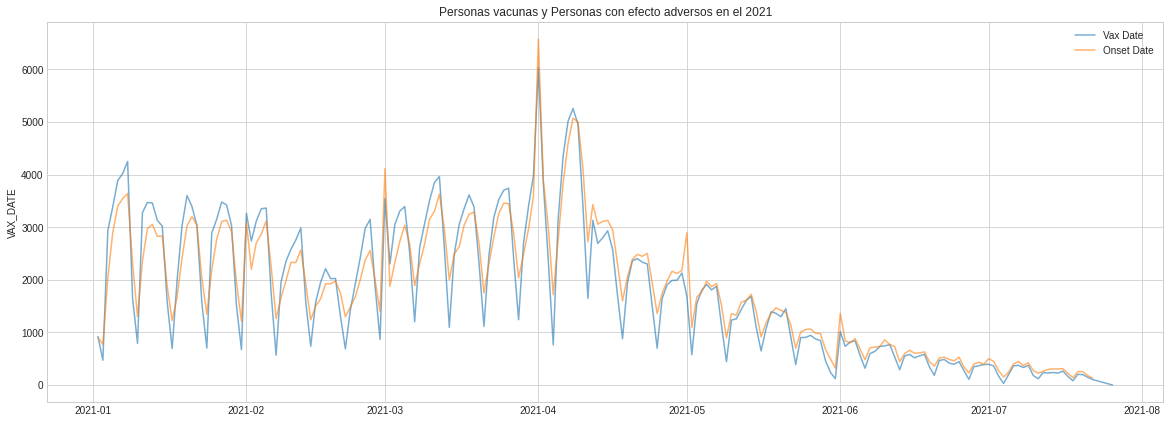

In [416]:
# grafico
fig1 = plt.figure(figsize=(20,7))
ax = fig1.add_subplot(1, 1, 1)
x = sns.lineplot(data = dataset_covid.loc[(dataset_covid['VAX_DATE'] > '2021-01-01') & (dataset_covid['VAX_DATE'] < '2021-08-01')].VAX_DATE.value_counts(),ax=ax, label=str('Vax Date'), alpha=0.6)
z = sns.lineplot(data = dataset_covid.loc[(dataset_covid['ONSET_DATE'] > '2021-01-01') & (dataset_covid['ONSET_DATE'] < '2021-08-01')].ONSET_DATE.value_counts(),ax=ax,label=str('Onset Date'), alpha=0.6)
plt.legend()
plt.title('Personas vacunas y Personas con efecto adversos en el 2021')
plt.show()

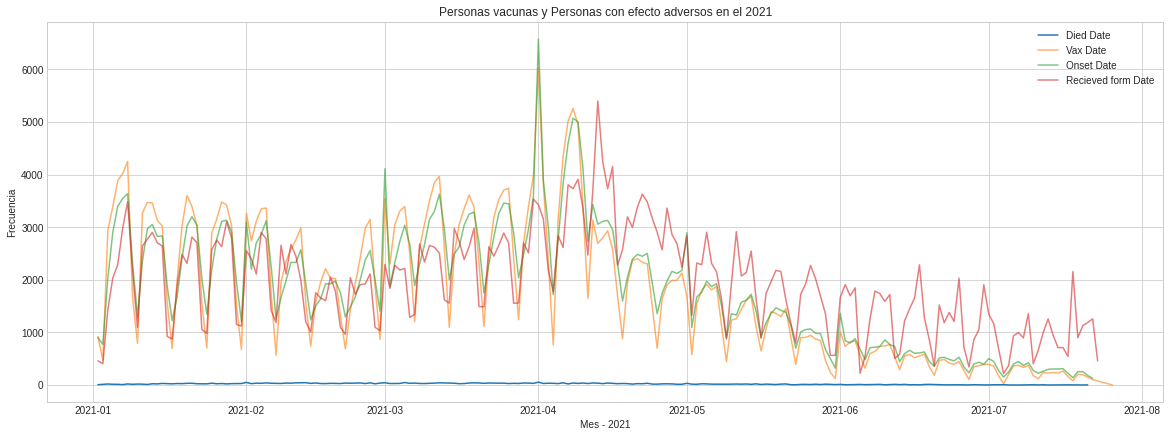

In [417]:
# grafico de todas las fechas
fig1 = plt.figure(figsize=(20,7))
ax = fig1.add_subplot(1, 1, 1)
a = sns.lineplot(data = dataset_covid.loc[(dataset_covid['DATEDIED'] > '2021-01-01') & (dataset_covid['DATEDIED'] < '2021-08-01')].DATEDIED.value_counts(),ax=ax,label=str('Died Date'))
x = sns.lineplot(data = dataset_covid.loc[(dataset_covid['VAX_DATE'] > '2021-01-01') & (dataset_covid['VAX_DATE'] < '2021-08-01')].VAX_DATE.value_counts(),ax=ax, label=str('Vax Date'), alpha=0.6)
z = sns.lineplot(data = dataset_covid.loc[(dataset_covid['ONSET_DATE'] > '2021-01-01') & (dataset_covid['ONSET_DATE'] < '2021-08-01')].ONSET_DATE.value_counts(),ax=ax,label=str('Onset Date'), alpha=0.6)
y = sns.lineplot(data = dataset_covid.loc[(dataset_covid['RECVDATE'] > '2021-01-01') & (dataset_covid['RECVDATE'] < '2021-08-01')].RECVDATE.value_counts(),ax=ax,label=str('Recieved form Date'), alpha=0.6)
plt.legend()
ax.set_xlabel('Mes - 2021')
ax.set_ylabel('Frecuencia')
plt.title('Personas vacunas y Personas con efecto adversos en el 2021')
plt.show()

# **13.NUMDAYS**

In [418]:
######################## BACKUP ##############################
#backup = dataset_covid.copy()
dataset_covid = backup.copy()

In [419]:
# numero de dias desde el dia del efecto adverso # aqui hay datos ERRADOS!!
#dataset_covid.NUMDAYS.dropna().astype(int).value_counts().sort_index(ascending=False)

36896         1
36573         1
36564         1
36561         1
36555         1
          ...  
4          7734
3         11763
2         21396
1         81861
0        166441
Name: NUMDAYS, Length: 551, dtype: int64

# **14. VAX_LOT, VAX_ROUTE, VAX_SITE**

# Tratamiento de Variables

In [ ]:
# Trabajo de Laboratorio -- MALA variable
removew = ['unknown', 'no', 'n/a', 'na', 'none yet', 'see above',
       'none at this time', 'none.', 'none to date', 'none yet.',
       'none reported', 'none so far', 'none known', 'not applicable',
       'none at this time.', 'blood work', 'see above.', 'non', 'none done',
       '0', 'as above', 'ultrasound', 'none needed', 'no.',
       'none taken', 'no tests','as above.', 'n/a.','none performed',
       'none as of yet', 'unknown.', 'none so far.', 'not known', 'pending',
       'no e', 'none', 'vital signs', 'none to date.', 'not yet',
       '?', '-', 'vitals', 'lab work', 'unk', 'no tests done', 
       'nothing', 'none noted', 'unkown', 'none required', 'no tests.',
       'denies','unknown at this time', 'vitals were taken - normal',
       'no medical test']

dataset_covid['LAB_DATA'] = dataset_covid['LAB_DATA'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.LAB_DATA.dropna().value_counts().head(100).index


In [ ]:
# Lugar donde se puso la vacuna
dataset_covid.V_ADMINBY.dropna().str.upper().value_counts(ascending = True)

In [ ]:
# Financiamiento para la vacuna
dataset_covid.V_FUNDBY.dropna().str.upper().value_counts(ascending = True)

In [ ]:
# Otras medicaciones por historial
omeds = ['none', 'unknown', 'no', 'none.', 'n/a','unk', 'na','unk', 'na',
            'nothing', 'none listed', 'none reported','no medications',
            'unkown', 'no known', 'non', 'not reported', 'none noted', '0',
            'no.','not available']
removew += omeds

dataset_covid['OTHER_MEDS'] = dataset_covid['OTHER_MEDS'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.OTHER_MEDS.value_counts()

In [ ]:
# Otras medicaciones por historial
ill = ['none known', 'no illnesses', 'no acute illness', 'no acute illnesses', 
       'none known.', 'no known illnesses', 'unknown.', 'denied',
       'i did not have any other illnesses.', 'none stated', 'no other illnesses', 
       'not applicable', 'no other illnesses.','none reported.', '-', 'no e',
       'none per patient','none documented', 'zero', 'nonr', 'none disclosed',
       'no illnesses at the time of vaccination.', 'none that i am aware of',
       'no illnesses.', '?', 'nome', 'non-smoker', 'n/a.', 'nope',
       'no known illness', 'nothing acute', 'none indicated',
       'no other illnesses at the time of vaccination and up to one month prior.',
       'no illness date of vaccination, unknown prior', 'none acute', 
       'none that i know of', 'unsure','none identified', 'none,', 'nonw', 
       'none reported by patient', 'no other illness', 'no  other illnesses.']
removew += ill

dataset_covid['CUR_ILL'] = dataset_covid['CUR_ILL'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.CUR_ILL.value_counts()

In [ ]:
# HISTORIAL MEDICO
historial = ['comments: list of non-encoded patient relevant history: patient other relevant history 1: none',
             'medical history/concurrent conditions: no adverse event (no reported medical history)',
             'medical history/concurrent conditions: no adverse event (no medical history reported)',
             'medical history/concurrent conditions: no adverse event (no reported medical history.)',
             'medical history/concurrent conditions: no adverse event (no medical history reported.)',
             'comments: no medical history was provided by the reporter.','not known', 'comments: unknown'
             ]
removew += historial

dataset_covid['HISTORY'] = dataset_covid['HISTORY'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.HISTORY.value_counts()

In [ ]:
# VACUNAS PREVIAS JAJJAJA
dataset_covid['PRIOR_VAX'] = dataset_covid['PRIOR_VAX'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.PRIOR_VAX.value_counts()

In [ ]:
# FORMULARIOS DE COLECTA DE DATOS
dataset_covid.FORM_VERS.value_counts()

In [ ]:
# VACUNAS PREVIAS

# nka = not known allergies

allergies = ['nka', 'nkda','no allergies', 'no known drug allergies', 
             'no known allergies.', 'no know allergies', 'no known allergies']
removew += allergies

dataset_covid['ALLERGIES'] = dataset_covid['ALLERGIES'].str.lower().replace(removew, np.nan) # incorrect values
dataset_covid.ALLERGIES.str.lower().value_counts()

In [ ]:
# Sintoma 1
print(dataset_covid.SYMPTOM1.str.lower().value_counts().head(100).index)
print(dataset_covid.SYMPTOMVERSION1.value_counts())

In [ ]:
# Sintoma 2
print(dataset_covid.SYMPTOM2.str.lower().value_counts().head(100).index)
print(dataset_covid.SYMPTOMVERSION2.value_counts())

In [ ]:
# Sintoma 3
print(dataset_covid.SYMPTOM3.str.lower().value_counts().head(100).index)
print(dataset_covid.SYMPTOMVERSION3.value_counts())

In [ ]:
# Sintoma 4
print(dataset_covid.SYMPTOM4.str.lower().value_counts().head(100).index)
print(dataset_covid.SYMPTOMVERSION4.value_counts())

In [ ]:
# Sintoma 5
print(dataset_covid.SYMPTOM5.str.lower().value_counts().head(100).index)
print(dataset_covid.SYMPTOMVERSION5.value_counts())

In [ ]:
# Conteo de fabricantes de vacunas para covid19 (VAX_MANU)
dataset_covid.VAX_MANU.value_counts()

In [ ]:
# Conteo por series de dosis ... esto esta alarmantes
dataset_covid.VAX_DOSE_SERIES.value_counts()

In [ ]:
# review the mistaked values... ESTO ESTA RARO
dataset_covid.loc[dataset_covid.VAX_DOSE_SERIES == "7+", ].head()

In [ ]:
# ruta de inoculacion de la vacuna .. interesante...
dataset_covid.VAX_ROUTE.value_counts()

In [ ]:
# zona anatomica de ncoulacion de vacuna
dataset_covid.VAX_SITE.value_counts()

**Obs.** Cantidad exhorbitante de reportes de vacunas de Covid19 (casi 98% de los datos)

**Obs.** Interesante los datos de el frabricante desconocido... por motivos de maleabilidad de los datos los eliminaremos al no ser muy representativo frente a los demas datos (representa solo un 0.16% de datos totales de vacunas para covid19)



# NLP en SYMTOMS_TEXT

In [ ]:
# Analisis textual de los sintomas, considerable numero...
dataset_covid.SYMPTOM_TEXT.unique().shape

In [ ]:
data = pd.read_csv('2021VAERSData.csv', index_col=0, encoding='latin-1')

In [ ]:
sintomas_objetivo = ['vaccine-associated enhanced disease', 'multisystem inflammatory syndrome in children', 'acute respiratory distress syndrome',
                     'acute cardiovascular injury', 'microangiopathy', 'heart failure', 'stress cardiomyopathy', 'coronary artery disease arrhythmia',
                     'myocarditis', 'Coagulation disorder', 'thromboembolism', 'haemorrhage', 'Acute kidney injury', 'Generalized convulsion', 
                     'Acute liver injury', 'anosmia','ageusia', 'Chilblain', 'lesion', 'Single organ cutaneous vasculitis', 'Erythema multiforme', 
                     'Anaphylaxis', 'Acute aseptic arthritis', 'Meningoencephalitis', 'Acute disseminated encephalomyelitis', 'Thrombocytopenia'
                     ]
sintomas_objetivo = list(map(str.lower,sintomas_objetivo))
sintomas_objetivo.sort()

In [ ]:
# Trabajando en Text
data.SYMPTOM_TEXT.fillna('None',inplace=True) #rellenar nan
data.SYMPTOM_TEXT = data.SYMPTOM_TEXT.str.lower() # convertir en minuscula
data.SYMPTOM_TEXT = data.SYMPTOM_TEXT.str.replace('[^\w\s]',' ') # limpiar signos
data.SYMPTOM_TEXT = data.SYMPTOM_TEXT.str.rstrip() # limpiar espacios antes
data.SYMPTOM_TEXT = data.SYMPTOM_TEXT.str.lstrip() # limpiar especio despues

In [ ]:
prueba = data.head(10000)

In [ ]:
from fuzzywuzzy import fuzz

for i in sintomas_objetivo:
  prueba[i] = ""
  print('Sintoma: ', i)
  for j in prueba.SYMPTOM_TEXT:
    if fuzz.partial_ratio(i,j) > 80:
      print(i,'---',j)
      prueba[i,j] = 1
    else:
      prueba[i] = 0


# # Make new columns indicating what will be imputed
# for col in cols_with_missing:
#     X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
#     X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

In [ ]:
data.loc[data.SYMPTOM_TEXT.str.contains('hrombocytopenia', na=False)].shape

In [ ]:
symptom.head(100)

In [ ]:
symptom.SYMPTOM1

In [ ]:
sympotom1.value_counts().head(100)

In [ ]:
symptom[symptom.SYMPTOM1.str.contains('oagulopathy')]

#### history

In [ ]:
# analisis de HISTORY
dataset_covid['HISTORY'] = dataset_covid['HISTORY'].str.lower().replace(palabras_errones, np.nan) # reemplazando valores incorrectos
dataset_covid.HISTORY.dropna().value_counts().sum() # revision de cantidad de valores utiles

# Notas previas

POSIBLES OBJETIVOS DEL TRABAJO DE INVESTIGACION:

1. Personalizacion de las vacunas Moderna, Pfizer  y Johnson & Johnson pra reducir efectos adversos en perfiles especificos en pacientes. Este objetivo requeriria de un dataset de control con pacientes que no presentaron reacciones adversas a las vacunas.

- Target: tipo de vacuna
- Features: Datos de los pacientes (alergias, comorbolidades, edad, sexo, 
enfermedades cronicas y actuales (historia clinica), vacunas previas, sintomas post aplicacion, hospitalizacion y dias de hospitilizacion, discapacidades...)

2. Series de tiempo frente antes y despues de la fecha de vacunacion.

3. Predecir el sexo y/o rango de edad basado en los sintomas presetnados post aplicacion de las vacunas A. B.

4. Predecir si el paciente requiere hospitalizacion basado en los sintomas que presenta al inocularse la vacuna por clusters (no supervisado).

5. Predecir que sintomas puede presentar el paciente en base a su sexo y la vacuna inoculada.

## Revisando repeticiones (codigo extra)


In [ ]:
# revision de valores exagerados
revision = merged.loc[1215401]

for i in revision.columns:
  repetidos = list(set(revision[i]))
  limpio = [x for x in repetidos if str(x) != 'nan']
  if len(limpio) > 2:
    print('\n*****Variable:', i, '*****')
    pprint(limpio)